In [1]:
# IO
import json
import os
from datasets import Dataset
from pathlib import Path

# Machine learning
import numpy as np
from sentence_transformers import SentenceTransformer

/home/machine_learning/.anaconda3/envs/ia4gov/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [1]:
os.sched_getaffinity(0)

NameError: name 'os' is not defined

In [2]:
# Constant
DATA_PATH = Path('../data/original/LA_FISCALITE_ET_LES_DEPENSES_PUBLIQUES_06022019.json')
MODEL_NAME = "dangvantuan/sentence-camembert-large"

In [3]:
with open(DATA_PATH) as f:
    data = json.load(f)

# Reformat with HF dataset

In [20]:
from datasets import Dataset, DatasetInfo

In [4]:
def get_question_list(data):
    questions = {}
    for r in data[0]["responses"]:
        question = r["questionTitle"]
        question_id = r["questionId"]
        questions[question_id] = question
    return questions


def get_question(data, question_id):
    question_id = str(question_id)
    question = None
    for r in data[0]["responses"]:
        if r["questionId"] == question_id:
            question = r["questionTitle"]
    return question


def get_response(data, question_id, return_none=False):
    question_id = str(question_id)
    responses = []
    for d in data:
        for r in d["responses"]:
            if r["questionId"] == question_id:
                responses.append(r["value"])
    if return_none is False:
        responses = [r for r in responses if r is not None]
    return responses

In [9]:
get_question_list(data)

{'162': "Quelles sont toutes les choses qui pourraient être faites pour améliorer l'information des citoyens sur l'utilisation des impôts ?",
 '163': 'Que faudrait-il faire pour rendre la fiscalité plus juste et plus efficace ?',
 '164': "Quels sont selon vous les impôts qu'il faut baisser en priorité ?",
 '206': 'Afin de financer les dépenses sociales, faut-il selon vous...',
 '205': "S'il faut selon vous revoir les conditions d'attribution de certaines aides sociales, lesquelles doivent être concernées ?",
 '165': 'Quels sont les domaines prioritaires où notre protection sociale doit être renforcée ?',
 '166': "Pour quelle(s) politique(s) publique(s) ou pour quels domaines d'action publique, seriez-vous prêts à payer plus d'impôts ?",
 '167': "Y a-t-il d'autres points sur les impôts et les dépenses sur lesquels vous souhaiteriez vous exprimer ?"}

In [14]:
question_id = 163
question = get_question(data, question_id=question_id)

responses = get_response(data, question_id=question_id)
partial_responses = responses[::20]
print("Question : ", question)
print("Example of answer:", partial_responses[0])

Question :  Que faudrait-il faire pour rendre la fiscalité plus juste et plus efficace ?
Example of answer: Repartir les richesses.  suppression de la taxe d habitation pour tous les français et de la csg reindexé les retraites  . Ne plus diviser les français (les patrons ont besoin des plus modestes et vice versa. Les patrons ne réussisses que si les plus modestes sont aussi avec eux) . Les français ne veulent plus de l assistanat mais veulent vivre dignement de leur salaire


In [34]:
data = Dataset.from_list(
    mapping=[{"content": r} for r in responses],
    info=DatasetInfo(description=f"Answer to question: {question}"),
)
data.add_column("embeddings", [None] * data.num_rows)

/home/machine_learning/.anaconda3/envs/ia4gov/lib/python3.11/site-packages/datasets/table.py:1395: FutureWarning: promote has been superseded by mode='default'.
  block_group = [InMemoryTable(cls._concat_blocks(list(block_group), axis=axis))]
/home/machine_learning/.anaconda3/envs/ia4gov/lib/python3.11/site-packages/datasets/table.py:1421: FutureWarning: promote has been superseded by mode='default'.
  table = cls._concat_blocks(blocks, axis=0)


Dataset({
    features: ['content', 'embeddings'],
    num_rows: 53724
})

In [35]:
def semantic_embedding(content, model):
    embeddings = model.encode(content)
    return {'embeddings':embeddings}

In [37]:
sts_model = SentenceTransformer(MODEL_NAME)
sts_model.max_seq_length = 512

No sentence-transformers model found with name /home/machine_learning/.cache/torch/sentence_transformers/dangvantuan_sentence-camembert-large. Creating a new one with MEAN pooling.


In [44]:
data = data.map(
    semantic_embedding,
    fn_kwargs={"model": sts_model},
    input_columns='content',
    num_proc=1,
    batch_size=256,
)

Map: 100%|██████████| 53724/53724 [22:41<00:00, 39.47 examples/s]


In [49]:
save_path = Path(f"../data/{question_id}")
save_path.mkdir(exist_ok=True)
data.save_to_disk(save_path)

Saving the dataset (1/1 shards): 100%|██████████| 53724/53724 [00:00<00:00, 305008.50 examples/s]


# Content exploration

In [11]:
from pacmap import PaCMAP
from umap import UMAP


def get_embeddings(data, model, indexes=None):
    if indexes is None:
        select_data = data
    else:
        select_data = [d for i, d in enumerate(data) if i in indexes]
    embeddings = model.encode(select_data, show_progress_bar=True)
    return embeddings


def get_embeddings_2d(data, indexes=None, n_components=2, distance="angular"):
    embeddings = get_embeddings(data, indexes)
    projector = PaCMAP(n_components=n_components, distance=distance)
    projector.fit(embeddings)
    embeddings_2d = projector.transform(embeddings, basis=embeddings)
    return embeddings_2d


def pacmap_embeddings(data, n_components=2, distance="angular", **kwargs):
    projector = PaCMAP(n_components=n_components, distance=distance, **kwargs)
    projector.fit(data)
    embeddings_2d = projector.transform(data, basis=data)
    return embeddings_2d


def umap_embeddings(data, n_components=2, metric="cosine", **kwargs):
    projector = UMAP(n_components=n_components, metric=metric, **kwargs)
    projector.fit(data)
    embeddings_2d = projector.transform(data)
    return embeddings_2d

## Topic definition

In [50]:
import matplotlib.pyplot as plt
from sklearn.cluster import HDBSCAN, DBSCAN, AgglomerativeClustering

**Protocol**
- project/calculate the embedding in new reduced space
- get the cluster
- reproject in 2D to display with cluster number.
- check some texts.

In [145]:
question_id = 163
question = get_question(data, question_id = question_id)

responses = get_response(data, question_id = question_id)
partial_responses = responses[::20]
print('Question : ')
print('Example of answer:', partial_responses[0])

Question : 
Example of answer: Repartir les richesses.  suppression de la taxe d habitation pour tous les français et de la csg reindexé les retraites  . Ne plus diviser les français (les patrons ont besoin des plus modestes et vice versa. Les patrons ne réussisses que si les plus modestes sont aussi avec eux) . Les français ne veulent plus de l assistanat mais veulent vivre dignement de leur salaire


In [ ]:
responses = get_response(data, question_id=question_id)
partial_responses = responses[::20]

embeddings = get_embeddings(partial_responses, sts_model)

In [15]:
embeddings_ = pacmap_embeddings(embeddings, n_components=10, random_state=42)
embeddings_2d = pacmap_embeddings(embeddings, n_components=2, random_state=42)

/home/machine_learning/.anaconda3/envs/ia4gov/lib/python3.11/site-packages/pacmap/pacmap.py:819: UserWarning: Warning: random state is set to 42
  warnings.warn(f'Warning: random state is set to {_RANDOM_STATE}')
/home/machine_learning/.anaconda3/envs/ia4gov/lib/python3.11/site-packages/pacmap/pacmap.py:819: UserWarning: Warning: random state is set to 42
  warnings.warn(f'Warning: random state is set to {_RANDOM_STATE}')


[-1  0  1  2  3  4  5  6  7  8  9 10 11 12]


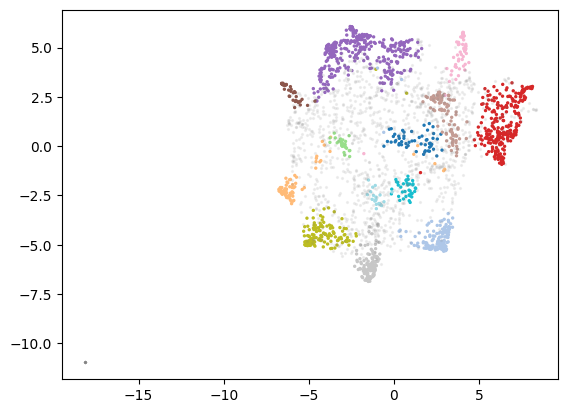

In [16]:
clusterer = HDBSCAN(
    cluster_selection_epsilon=0.4,
    alpha=1,
    min_samples=20,
    min_cluster_size=20
)

clusterer.fit(embeddings_)
categories = clusterer.labels_
unique_categories = np.unique(categories)
print(unique_categories)

mask = categories >= 0
plt.scatter(*embeddings_2d[mask].T, s=2, c=categories[mask], cmap=plt.cm.tab20)
plt.scatter(*embeddings_2d[~mask].T, s=2, c='grey', alpha=0.1)
# plt.scatter(*embeddings_2d[categories== 8].T, s=20, cmap=plt.cm.tab10)
plt.show()

In [17]:
n = 5
categories = clusterer.labels_
for c in np.unique(categories[categories >= 0]):
    idx = np.where(categories == c)[0]
    selected_responses = [r for i, r in enumerate(partial_responses) if i in idx]
    print(f"############ CATEGORIE {c} #########")
    print("Size of the cluster:", len(idx))
    samples = [np.random.choice(selected_responses) for _ in range(n)]
    for rep in samples:
        print("--", rep)
    print("\n")

############ CATEGORIE 0 #########
Size of the cluster: 54
-- En premier lieu, il conviendrait de réduire le nombre d'impôts et de taxes visant les citoyens.
Supprimer purement et simplement la taxe d'habitation.
Supprimer la taxe foncière qui est un impôt particulièrement injuste parce qu'il touche la propriété acquise, qu'il s'agisse ou pas de la résidence principale, conduisant selon les localités à payer deux fois ou plus sa propriété.
Pour alimenter les caisses des collectivités territoriales, il faudrait qu'elles déterminent une part de la TVA ou de l'IRPP, ce qui de surcroît les conduirait à jouer sur l'attractivité de leur territoire.
-- Impot sur le revenu pour tous en comptant les aides sociales ou pour personne
Annulation de la taxe d’habitation pour tout le monde
Arrêt du matraque fiscal des classes moyennes superieures
-- - supprimer la taxe d'amenagement
- retablir l'ISF
- faire en sorte que tous paient la taxe d'habitation ou tous en soient exonérés
-- La suppression de 

**OBSERVATIONS**
- simples sentences are well clustered 
- long sentences embeddes many ideas and proposals etc...
- some item are not completelly related to the question.
- there are many doppleganger.

**CONCLUSION**
- It works well at first sight but it is not possible to exploit directly the data like this.
- the item should be evaluate regarding the question.
- the main idea / proposal should be split.

**PROPOSALS**
- use LLM to pre-process the items.
- ideally, do the work of every data.
- to avoid overuse of RAM, use HF datasets
- avoid to analyze twice the same content.
    - use embedding to drop duplicates.
    - apply same results to duplicates.

**OBSERVATIONS**
- failures list : 11

# Archives

In [183]:
# from bertopic.vectorizers import OnlineCountVectorizer, ClassTfidfTransformer
# from sklearn.feature_extraction.text import CountVectorizer
# from spacy.lang.fr.stop_words import STOP_WORDS as fr_stop
# import spacy
# from pandas import DataFrame

# nlp = spacy.load("fr_core_news_sm", disable=['parser', 'ner'])

# fr_stop = list(fr_stop) + ['qu']

# bow = {}
# tfidf_results = {}
# for c in np.unique(categories):
#     idx = np.where(categories == c)[0]
#     selected_responses = [r for i, r in enumerate(partial_responses) if i in idx]
#     ocv = CountVectorizer(stop_words=fr_stop)
#     selected_lemms = []
#     for sr in selected_responses:
#         doc = nlp(sr)
#         lemmas = ' '.join([d.lemma_ for d in doc])
#         selected_lemms.append(lemmas)
#     word_count_vector = ocv.fit_transform(selected_lemms)
#     tfidf_transformer = ClassTfidfTransformer()
#     tfidf_transformer.fit(word_count_vector)
#     tfidf_results[c] = DataFrame(tfidf_transformer.idf_, index=ocv.get_feature_names_out()).sort_values(by=0, ascending=True)

### Apply clustering on embeddings

In [55]:
# from scipy.cluster.hierarchy import dendrogram

# def plot_dendrogram(model, **kwargs):
#     # Create linkage matrix and then plot the dendrogram

#     # create the counts of samples under each node
#     counts = np.zeros(model.children_.shape[0])
#     n_samples = len(model.labels_)
#     for i, merge in enumerate(model.children_):
#         current_count = 0
#         for child_idx in merge:
#             if child_idx < n_samples:
#                 current_count += 1  # leaf node
#             else:
#                 current_count += counts[child_idx - n_samples]
#         counts[i] = current_count

#     linkage_matrix = np.column_stack(
#         [model.children_, model.distances_, counts]
#     ).astype(float)

#     # Plot the corresponding dendrogram
#     dendrogram(linkage_matrix, **kwargs)

In [56]:
# clusterer = AgglomerativeClustering(distance_threshold=30, linkage='ward', n_clusters=None)

# clusterer.fit(embeddings)
# categories = clusterer.labels_
# unique_categories = np.unique(categories)
# print(unique_categories)

In [57]:
# plot_dendrogram(clusterer, truncate_mode="level", p=3)